In [0]:
import urllib 
import os
import tarfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

from zlib import crc32

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.image as mimg

from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from scipy import stats

In [0]:
def updateData(DOWNLOAD_URL, DOWNLOAD_DIRECTORY, file_name):
   
#     urllib.request.urlretrieve(DOWNLOAD_URL, os.path.join(DOWNLOAD_DIRECTORY,file_name))

    TARFILE_DIRECTORY = os.path.join(DOWNLOAD_DIRECTORY,file_name)
    
    tgz_load = tarfile.open(TARFILE_DIRECTORY)
    tgz_load.extractall(DOWNLOAD_DIRECTORY)
    tgz_load.close

In [74]:
pwd

'/content'

In [0]:
updateData('https://github.com/ageron/handson-ml2/blob/master/datasets/housing/housing.tgz', 
          os.path.abspath('.'),
          'housing.tgz')

In [76]:
def load_housing_data(HOUSING_PATH):
    return pd.read_csv(HOUSING_PATH)
    
housing = load_housing_data('housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [77]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [78]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [79]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


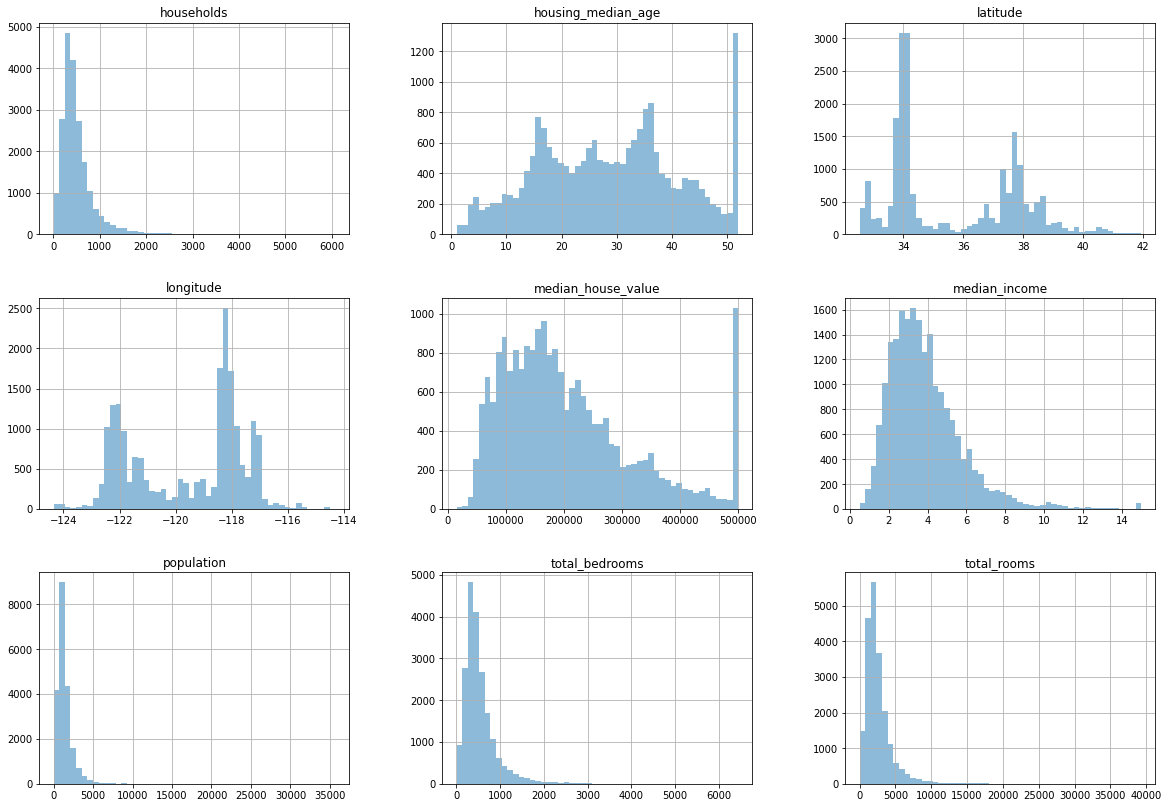

In [80]:
housing.hist(figsize=(20,14), alpha=0.5, bins=50)
plt.show()

In [81]:
def split_train_test(data, ratio, random_state=101, shuffle=True):
    
    np.random.seed(random_state)
    shuffle_indices = np.random.permutation(len(data))
    print("shuffle_indices:", shuffle_indices)
    
    size = int(len(data)*0.2)
    train_indices = shuffle_indices[size:]
    test_indices = shuffle_indices[:size]
    
    print("train_indices", len(train_indices))
    print("test_indices", len(test_indices))
    
    return data.iloc[train_indices], data.iloc[test_indices]

train, test = split_train_test(housing, 0.2, random_state=101, shuffle=True)


shuffle_indices: [16086  8816  7175 ... 17745 17931 13151]
train_indices 16512
test_indices 4128


In [0]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [0]:
housing_with_id['id'] = housing['longitude'] * 100 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [85]:
len(train_set), len(test_set)

(16406, 4234)

In [0]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [87]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [88]:
len(train_set), len(test_set)

(16512, 4128)

In [0]:
housing['income_cat'] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

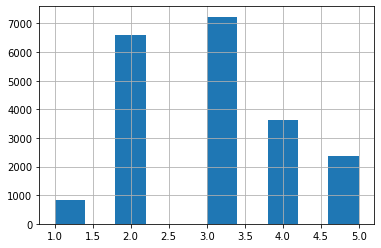

In [90]:
housing['income_cat'].hist()

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices,test_indices in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_indices]
  strat_test_set = housing.loc[test_indices]

In [92]:
len(strat_train_set),  len(strat_test_set)

(16512, 4128)

In [93]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [94]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [0]:
housing = strat_train_set.copy() 

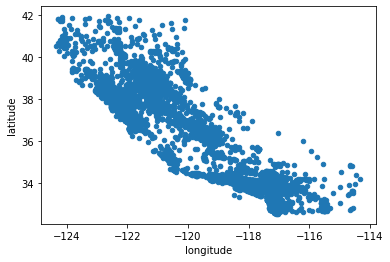

In [97]:
housing.plot(kind='scatter', x='longitude', y='latitude')

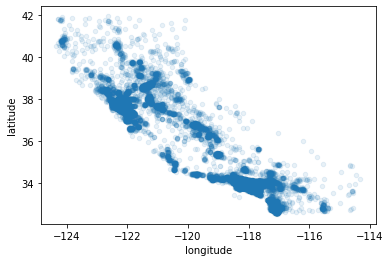

In [98]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

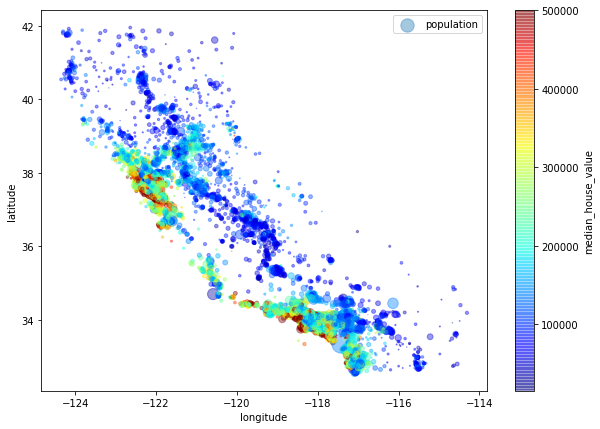

In [99]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha = 0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.show()

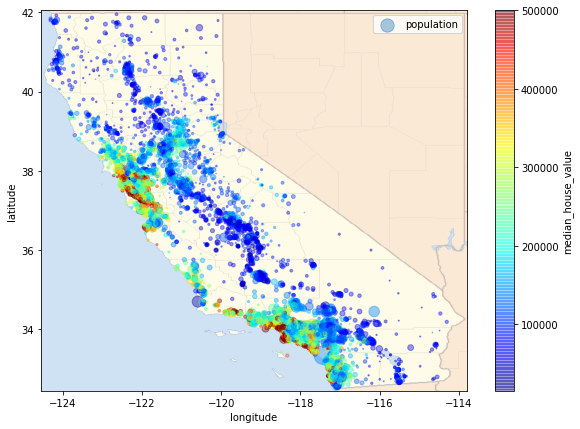

In [100]:
california_image = mimg.imread('california.png', )

ax = housing.plot(kind='scatter', x='longitude', y='latitude', alpha = 0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.imshow(california_image, alpha=0.5, extent=[-124.55, -113.80, 32.45, 42.05])
plt.show()

In [0]:
corr_matrix = housing.corr()

In [102]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

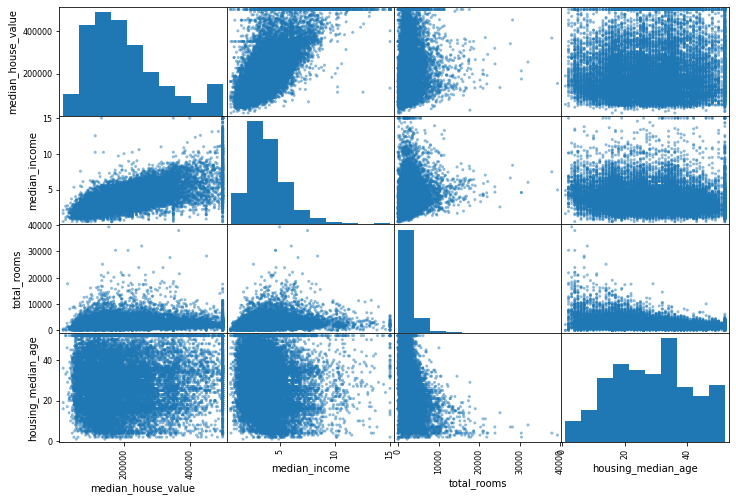

In [103]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

(0.0, 16.0, 0.0, 550000.0)

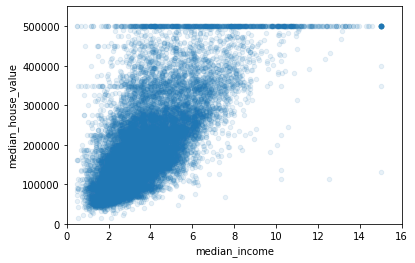

In [104]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [106]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [107]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning

In [0]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [109]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
imputer = SimpleImputer(strategy='median')

In [0]:
housing_num = housing.drop('ocean_proximity',  axis=1)

In [112]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [113]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [114]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [0]:
X = imputer.transform(housing_num)

In [116]:
X.shape

(16512, 8)

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

In [118]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [119]:
imputer.strategy

'median'

In [120]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [121]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [122]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
type(housing_cat_encoded)

numpy.ndarray

In [123]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [124]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [125]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [126]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [0]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                      bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

In [0]:
attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [129]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [0]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributeAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [131]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [0]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
               ('num pipeline', num_pipeline, num_attribs),
               ('cat pipline', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [133]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [134]:
housing_prepared.shape

(16512, 16)

# Select And train Model

In [135]:
lin_reg = LinearRegression()


lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [136]:
some_data = housing.iloc[:5]
some_labels  = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)

lin_reg.predict(some_data_prepared)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [137]:
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [138]:
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_prediction)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848923


In [139]:
lin_mae = mean_absolute_error(housing_labels, housing_prediction)

print(lin_mae)

49439.89599001897


In [140]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [141]:
housing_prediction = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_prediction)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


# Fine Tune your model

- CV
- Grid search cv
- Random search cv

In [0]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_score = np.sqrt(-scores)


In [145]:
print(tree_rmse_score)

[70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]


In [0]:
def display_score(score):
  print("scores:", score)
  print("mean:", score.mean())
  print("std:", score.std())


In [148]:
display_score(tree_rmse_score)

scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
mean: 71407.68766037929
std: 2439.4345041191004


In [151]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_reg_score = np.sqrt(-scores)

display_score(lin_reg_score)

scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean: 69052.46136345083
std: 2731.674001798344


## Find Best Params

In [0]:
# search grid params

forest_reg = RandomForestRegressor()

param_grid = [
    {'n_estimators':[3,10, 30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

grid_search = GridSearchCV(forest_reg, param_grid=param_grid, scoring='neg_mean_squared_error', return_train_score=True)

In [158]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [159]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [160]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [175]:
np.sqrt(-grid_search.best_score_) 

50056.53177178338

In [164]:
best_estimator = grid_search.best_estimator_

print("type:", type(best_estimator))

best_estimator

type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
grid_results = grid_search.cv_results_

In [173]:
for params, mean_test_score in zip(grid_results['params'], grid_results['mean_test_score']):
  print(params, np.sqrt(-mean_test_score)) 

{'max_features': 2, 'n_estimators': 3} 65561.00051326882
{'max_features': 2, 'n_estimators': 10} 55468.06010046309
{'max_features': 2, 'n_estimators': 30} 52678.33435536232
{'max_features': 4, 'n_estimators': 3} 59787.82027813403
{'max_features': 4, 'n_estimators': 10} 52438.5321707656
{'max_features': 4, 'n_estimators': 30} 50752.64442434168
{'max_features': 6, 'n_estimators': 3} 58683.8906215272
{'max_features': 6, 'n_estimators': 10} 52707.49805603038
{'max_features': 6, 'n_estimators': 30} 50291.479843929985
{'max_features': 8, 'n_estimators': 3} 58805.38855019428
{'max_features': 8, 'n_estimators': 10} 52188.71901785077
{'max_features': 8, 'n_estimators': 30} 50056.53177178338
{'bootstrap': False, 'max_features': 2, 'n_estimators': 3} 62063.286561858964
{'bootstrap': False, 'max_features': 2, 'n_estimators': 10} 53822.8750835408
{'bootstrap': False, 'max_features': 3, 'n_estimators': 3} 60469.2371994709
{'bootstrap': False, 'max_features': 3, 'n_estimators': 10} 52384.968683790044

In [184]:
feature_importance = grid_search.best_estimator_.feature_importances_
np.count_nonzero(feature_importance)

16

In [194]:
np.count_nonzero(num_attribs) + np.count_nonzero(cat_encoder.categories_) + np.count_nonzero(['rooms_per_hhold','pop_per_hhold','bedrooms_per_room'])

16

In [0]:
cat_encoder = full_pipeline.named_transformers_['cat pipline']

In [204]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [0]:
extra_attribs = ['rooms_per_hhold','pop_per_hhold','bedrooms_per_room']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

In [209]:
attributes = num_attribs + cat_one_hot_attribs + extra_attribs
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room']

In [210]:
for feat, attrib in zip(feature_importance, attributes):
  print(feat, attrib)

0.07601037529126906 longitude
0.06418831515639736 latitude
0.0404517072899156 housing_median_age
0.014694148815561879 total_rooms
0.014782646029776756 total_bedrooms
0.015148835585431815 population
0.013595945874558119 households
0.3789540023748316 median_income
0.05329665369734448 <1H OCEAN
0.10974130272180375 INLAND
0.05327042309875244 ISLAND
0.005018175643227414 NEAR BAY
0.1556239636662024 NEAR OCEAN
9.098057384233585e-05 rooms_per_hhold
0.0023221445482138423 pop_per_hhold
0.0028103796328710446 bedrooms_per_room


In [212]:
sorted(zip(feature_importance, attributes), reverse=True)

[(0.3789540023748316, 'median_income'),
 (0.1556239636662024, 'NEAR OCEAN'),
 (0.10974130272180375, 'INLAND'),
 (0.07601037529126906, 'longitude'),
 (0.06418831515639736, 'latitude'),
 (0.05329665369734448, '<1H OCEAN'),
 (0.05327042309875244, 'ISLAND'),
 (0.0404517072899156, 'housing_median_age'),
 (0.015148835585431815, 'population'),
 (0.014782646029776756, 'total_bedrooms'),
 (0.014694148815561879, 'total_rooms'),
 (0.013595945874558119, 'households'),
 (0.005018175643227414, 'NEAR BAY'),
 (0.0028103796328710446, 'bedrooms_per_room'),
 (0.0023221445482138423, 'pop_per_hhold'),
 (9.098057384233585e-05, 'rooms_per_hhold')]

# Evaluate system on Test Set

In [213]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND


In [0]:
x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [221]:
x_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,INLAND
...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,INLAND


In [224]:
final_model = grid_search.best_estimator_

x_test_prepared = full_pipeline.transform(x_test)

final_prediction = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_prediction)
final_rmse = np.sqrt(final_mse)

final_rmse

47587.1518147852

In [226]:
confidence = 0.95
squared_errors = (final_prediction - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale = stats.sem(squared_errors)))

array([45593.72286661, 49500.36839105])